# Basin orientation compared to fault strike

In [1]:
# first, import modules
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import numpy as np
import numpy.ma as ma
import seaborn as sns

import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import swath_profile as swath

Define the base directory and some filenames. Read in the shapefile of points along the SAF

In [3]:
base_dir = '/media/TopographicData/TopographicData/san_andreas/'
data_dir = '/media/TopographicData/TopographicData/san_andreas/SAF_combined/SAF_only/'
fname_prefix='SAF_only'
basin_shp = data_dir+fname_prefix+'_channel_slopes_by_basin_SO3.shp'
basin_gdf = gpd.read_file(basin_shp)
fault_pts = gpd.read_file(data_dir+'SanAndreasPoints.shp')

max_slope = 0.35 # define the max slope for normalising colourmaps
this_cmap = 'Reds'

## Rose diagrams

Let's make some rose diagrams of the orientation of the fault strike and the orientation of the drainage basins

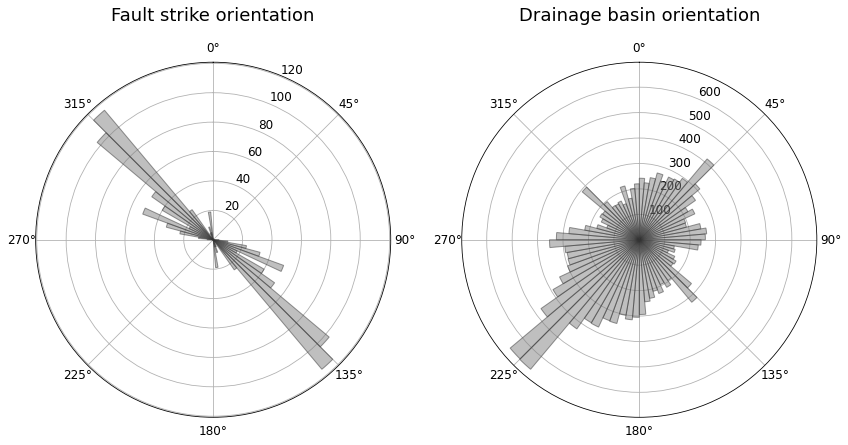

In [9]:
# bin the orientations into 10 degree bins.
bin_width = 5
bin_edges = np.arange(0, 360+bin_width, bin_width)
basins_hist, bin_edges = np.histogram(basin_gdf['azimuth'], bins=bin_edges)

# read in the fault azimuth shapefile
pts = gpd.read_file(data_dir+'SanAndreasPoints.shp')
# double the strikes with directions at 180 degrees to get a mirrored rose diagram
strikes = pts['azimuth'].values
strikes_mirrored = strikes + 180
all_strikes = np.concatenate([strikes, strikes_mirrored])
strike_hist, bin_edges = np.histogram(all_strikes, bins=bin_edges)

# set up the figure
fig = plt.figure(figsize=(14,8))

# set up the fault strike subplot
ax = fig.add_subplot(121, projection='polar')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_title('Fault strike orientation', y=1.1, fontsize=18)
ax.bar(np.deg2rad(bin_edges[0:-1]), strike_hist, width=np.deg2rad(bin_width), align='edge', edgecolor='0.2', color='0.5', zorder=2, alpha=0.5)
ax.tick_params(labelsize=12)

# set up the basin orientation subplot
ax = fig.add_subplot(122, projection='polar')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_title('Drainage basin orientation', y=1.1, fontsize=18)
ax.tick_params(labelsize=12)

# plot the histogram as bars. The bin edges are used as the left hand coordinate for the bars, minus the last edge. The histogram counts are the bar heights.
ax.bar(np.deg2rad(bin_edges[0:-1]), basins_hist, width=np.deg2rad(bin_width), align='edge', edgecolor='0.2', color='0.5', zorder=2, alpha=0.5)
#plt.subplots_adjust(wspace=0.5)
fig.savefig(data_dir+'SAF_rose_diagrams.png', dpi=300)

## Basin orientation along fault

Let's make another plot of the basin orientation compared to fault strike along the fault. We'll weight the basins by drainage area (larger weight to bigger basins), and colour the points by the median channel gradient.

0.00050088003625
0.000499599759


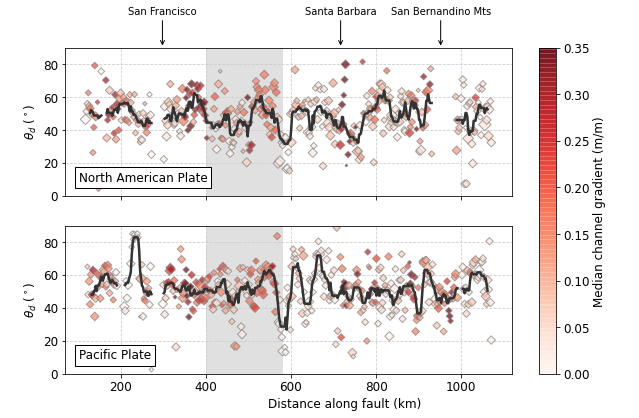

In [5]:
# now do the plotting along fault
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,6), sharex=True)
ax = ax.ravel()
# make a big subplot to allow sharing of axis labels
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# set the default colourmap
plt.rc('image', cmap='gray')

# plot the channel slope data
titles = ['North American Plate', 'Pacific Plate']
for i, title in enumerate(titles):
    # set up each subplot
    ax[i].grid(color='0.8', linestyle='--', which='both')
    ax[i].set_ylim(0,90)
    ax[i].text(0.03,0.1, titles[i], fontsize=12, transform=ax[i].transAxes, bbox=dict(facecolor='white'))
    ax[i].set_ylabel('$\\theta_d$ ($^\circ$)')

    # first, all the basins east of the fault (direction < 0)
    if i == 0:
        this_df = basin_gdf[basin_gdf['direction'] < 0]
    else:
    # then all the basins west of the fault (direction > 0)
        this_df = basin_gdf[basin_gdf['direction'] > 0]

    # group by the fault dist and get the mean deflection at each distance weighted by drainage area (larger areas = higher weights)
    g = this_df.groupby(['fault_dist'])
    gr = g.apply(lambda x: pd.Series(np.average(x['deflection'], weights=x['basin_area'])).reset_index(name='Deflection_weighted')).reset_index()
    area = this_df.groupby(['fault_dist'])['basin_area'].median()
    slope = this_df.groupby(['fault_dist'])['slope_medi'].median()
    
    # plot the deflection along fault and colour by median channel slope in each basin
    print(slope.min())
    norm = colors.Normalize(vmin=0, vmax=max_slope)
    pcm = ax[i].scatter(x=gr['fault_dist'], y=gr['Deflection_weighted'], c=slope, cmap=this_cmap, norm=norm, edgecolor='0.5', zorder=2, s=area/1000, marker='D', alpha=0.7)
    ax[i].axvspan(400, 580, facecolor='0.8', alpha=0.6, zorder=1)


    # rolling median
    slopes_df = gr.sort_values(by='fault_dist')
    slopes_df['rollmedian'] = slopes_df['Deflection_weighted'].rolling(10, center=True).median()
    #print(slopes_df)

    # create a mask for gaps in the median slopes
    these_dists = slopes_df['fault_dist'].values
    mask_starts = np.where(these_dists-np.roll(these_dists,1) > 10)[0]
    #print(mask_starts)
    mc = ma.array(slopes_df['rollmedian'].values)
    mc[mask_starts] = ma.masked
    ax[i].plot(slopes_df['fault_dist'], mc, c='0.2', zorder=100, lw=2.5, ls='-', alpha=1)

# placenames
labels_df = pd.read_csv(base_dir+'Uplift_rates/placenames.csv')
labels = labels_df['Label']
labels_dist = labels_df['fault_dist']
for i in range(0, len(labels)):
    ax[0].annotate(labels[i], xy=(labels_dist[i],90), xytext=(labels_dist[i], 110), ha='center', fontsize=10, arrowprops=dict(facecolor='k', arrowstyle="->"))

# finalise the figure
plt.xlabel('Distance along fault (km)')
fig.colorbar(pcm, ax=ax, label='Median channel gradient (m/m)')
plt.show()

In [6]:
# Save the figure
fig.savefig(data_dir+fname_prefix+'_basins_deflection.png', dpi=300, facecolor='white')
plt.clf()

<Figure size 432x288 with 0 Axes>

## Boxplots

Maybe boxplots of the angle along strike (or violin plots...) will say something more useful

In [7]:
# create some bins. Let's try analysing this every 50 km along fault
bin_width = 20
bin_array = np.arange(0, basin_gdf['fault_dist'].max()+bin_width, bin_width)

/home/bjdd72/miniconda3/envs/fault-swath/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


      bins  slope_medi
5    100.0    0.002387
6    120.0    0.140520
7    140.0    0.154995
8    160.0    0.159204
9    180.0    0.202969
10   200.0    0.140834
11   220.0    0.098676
12   240.0    0.073834
13   260.0    0.027379
15   300.0    0.060823
16   320.0    0.037193
17   340.0    0.267416
18   360.0    0.265012
19   380.0    0.279310
20   400.0    0.130326
21   420.0    0.076805
22   440.0    0.089874
23   460.0    0.072824
24   480.0    0.077671
25   500.0    0.155043
26   520.0    0.156937
27   540.0    0.179940
28   560.0    0.057329
29   580.0    0.009683
30   600.0    0.052126
31   620.0    0.071839
32   640.0    0.038360
33   660.0    0.026626
34   680.0    0.069286
35   700.0    0.101771
36   720.0    0.420509
37   740.0    0.089111
38   760.0    0.055038
39   780.0    0.088570
40   800.0    0.118598
41   820.0    0.062797
42   840.0    0.042823
43   860.0    0.071908
44   880.0    0.117442
45   900.0    0.158906
46   920.0    0.113883
49   980.0    0.079243
50  1000.0 

/home/bjdd72/miniconda3/envs/fault-swath/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Number of boxes:  48


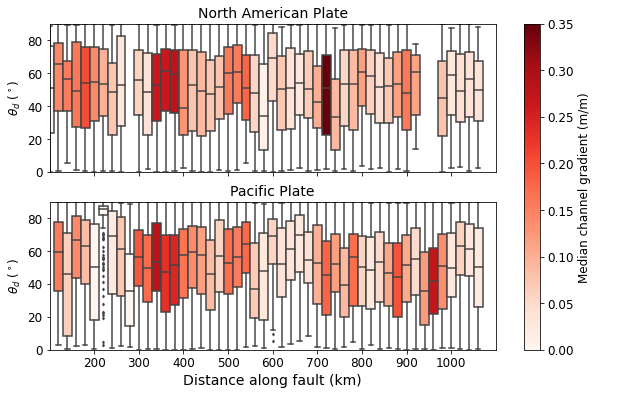

In [8]:
# now do the plotting along fault
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,6), sharex=True)
ax = ax.ravel()
# make a big subplot to allow sharing of axis labels
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

# plot the channel slope data
titles = ['North American Plate', 'Pacific Plate']
for i, title in enumerate(titles):
    # set up each subplot
    #ax[i].grid(color='0.8', linestyle='--', which='both')
    ax[i].set_ylim(0,90)
    #ax[i].text(0.03,0.1, titles[i], fontsize=12, transform=ax[i].transAxes, bbox=dict(facecolor='white'))
    ax[i].set_title(titles[i], fontsize=14)
    
    # add grey bar for creeping segment
    #ax[i].axvspan(400, 580, facecolor='0.8', alpha=0.6)

    # first, all the basins east of the fault (direction < 0)
    if i == 0:
        this_df = basin_gdf[basin_gdf['direction'] < 0]
    else:
    # then all the basins west of the fault (direction > 0)
        this_df = basin_gdf[basin_gdf['direction'] > 0]
        
    # group by the bins and show a boxplot of the deflection in each bin
    bins = pd.cut(this_df['fault_dist'], bin_array, labels = bin_array[:-1])
    this_df['bins'] = bins
    #print(this_df[this_df['bins'] == 110])
    count = this_df.groupby(['bins'])['slope_medi'].count()
    
    # make a colourmap based on the median slope values and extract the colours
    slope = this_df.groupby(['bins'])['slope_medi'].median().reset_index()
    slope = slope[np.isnan(slope['slope_medi']) == False]
    print(slope)
    these_slopes = slope['slope_medi'].values
    rgba_colours = swath.rgba_colours_from_array(these_slopes, vmin=0, vmax=max_slope, base_cmap=this_cmap)
    print("Number of colours", len(rgba_colours))
    
    # make the boxplot 
    bp = sns.boxplot(y='deflection', x='bins', data=this_df, width=bin_width, ax=ax[i], order=range(0,1100), fliersize=2, zorder=2)
    #print(bp)
    
    print("Number of boxes: ", len(bp.artists))
    for x, mybox in enumerate(bp.artists):
        # Change the appearance of that box
        mybox.set_facecolor(rgba_colours[x])
        #mybox.set_alpha(0.7)
    
    # fix the ticks
    ax[i].set_xlabel('')
    ax[i].set_xlim(100,1100)
    ax[i].set_xticks(np.arange(200,1100,100))
    ax[i].set_ylabel('$\\theta_d$ ($^\circ$)')

ax[1].set_xlabel('Distance along fault (km)', fontsize=14)

#new_cmap = ListedColormap(rgba_colours, name='slope_colours')
norm = colors.Normalize(vmin=0, vmax=max_slope)

fig.colorbar(cm.ScalarMappable(norm=norm, cmap=this_cmap), ax=ax, label='Median channel gradient (m/m)')
    

In [24]:
fig.savefig(data_dir+fname_prefix+'_basins_deflection_boxplots.png', dpi=300, facecolor='white')
plt.clf()

<Figure size 432x288 with 0 Axes>